# Women in Data Science Dataset

**Dataset:** Women in Data Science (91,713 encounters)  
**Microskill:** Model Comparison  
**Date:** February 13, 2025  
**Authors:** Jeremy Balch & Mackenzie Meni

### To Do List

- [ ] Upsampling and downsampling and assess performance by category  
- [ ] Debiasing strategies  
- [ ] Switch model architecture (RF, XGBoost, etc.)  
- [ ] Switch feature set (use all features, use subset of features)  
- [ ] Switch evaluation metric (AUROC, Accuracy, etc.)  
- [ ] Bootstrap for confidence intervals 


## Import Libraries

In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tableone import TableOne
import warnings
from sklearn.model_selection import train_test_split
warnings.filterwarnings("ignore")


## Load our preprocessed data from notebook '1_data_handling.ipynb'

In [65]:
data = pd.read_csv('preprocessed_data.csv')

## Creating the train test split for the Random Forrest model

In [66]:
# Drop the 'gender_M' and 'ethnicity_Other' columns
data = data.drop(columns=['gender_M', 'ethnicity_Other/Unknown'])

# Define your features and target variable
X = data.drop('hospital_death', axis=1)  # Features
y = data['hospital_death']               # Target variable

# Perform the train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Display the shapes of the resulting datasets
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)



# Shapes should be:
# X_train shape: (62060, 38)
# X_test shape: (15515, 38)
# y_train shape: (62060,)
# y_test shape: (15515,)


X_train shape: (62060, 38)
X_test shape: (15515, 38)
y_train shape: (62060,)
y_test shape: (15515,)


### Random Forest Model

In [67]:

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import joblib

# Initialize the Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
rf_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")


# Save the model
joblib.dump(rf_model, "original_data_random_forest_model.pkl")


# Calculate AUROC
from sklearn.metrics import roc_auc_score
y_pred_proba = rf_model.predict_proba(X_test)[:, 1]
auroc = roc_auc_score(y_test, y_pred_proba)
print(f"AUROC: {auroc:.2f}")

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Print confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Accuracy: 0.92
AUROC: 0.84
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.99      0.96     14214
           1       0.59      0.21      0.31      1301

    accuracy                           0.92     15515
   macro avg       0.76      0.60      0.63     15515
weighted avg       0.90      0.92      0.90     15515

Confusion Matrix:
[[14027   187]
 [ 1032   269]]


# Mackenzie's messy model code below:

In [19]:
import numpy as np
import torch

# Ensure y_train and y_test are NumPy arrays
if isinstance(y_train, pd.Series):
    y_train = y_train.to_numpy()
if isinstance(y_test, pd.Series):
    y_test = y_test.to_numpy()

# Convert feature matrices (X_train, X_test) to PyTorch tensors
X_train_tensor = torch.tensor(X_train.astype(np.float32), dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.astype(np.float32), dtype=torch.float32)

# Convert labels (y_train, y_test) to PyTorch tensors
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Print shapes to verify
print("X_train_tensor shape:", X_train_tensor.shape)
print("y_train_tensor shape:", y_train_tensor.shape)
print("X_test_tensor shape:", X_test_tensor.shape)
print("y_test_tensor shape:", y_test_tensor.shape)


ValueError: could not convert string to float: 'Emergency Department'

In [26]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
from torch.utils.data import DataLoader, TensorDataset

# Convert data to PyTorch tensors
X_train_tensor =  X_train.astype(np.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = X_test.astype(np.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Create DataLoaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Define the MLP model
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size=64, num_classes=2):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, hidden_size // 2)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_size // 2, num_classes)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu2(self.fc2(x))
        x = self.fc3(x)  # No softmax during training (CrossEntropyLoss expects raw logits)
        return x

# Initialize model
input_size = X_train.shape[1]
num_classes = len(set(y_train))  # Assuming y_train has labels like 0,1
model = MLP(input_size, hidden_size=64, num_classes=num_classes)

# Define optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# Train the model
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss / len(train_loader):.4f}")

# Evaluate the model
model.eval()
y_pred_list = []
y_pred_proba_list = []
with torch.no_grad():
    for batch_X, batch_y in test_loader:
        outputs = model(batch_X)
        probabilities = torch.softmax(outputs, dim=1)
        predictions = torch.argmax(probabilities, dim=1)

        y_pred_list.extend(predictions.cpu().numpy())
        y_pred_proba_list.extend(probabilities[:, 1].cpu().numpy())

# Compute evaluation metrics
accuracy = accuracy_score(y_test, y_pred_list)
auroc = roc_auc_score(y_test, y_pred_proba_list)

print(f"Accuracy: {accuracy:.2f}")
print(f"AUROC: {auroc:.2f}")
print("Classification Report:")
print(classification_report(y_test, y_pred_list))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_list))


ValueError: could not determine the shape of object type 'Series'

# Retrain your Random Forest model with your altered data

In [68]:
# Loading altered datasets
data_altered_20_percent_african_american= pd.read_csv('data_altered_20_percent_african_american.csv')
data_altered_80_percent_female = pd.read_csv('data_altered_80_percent_female.csv')

In [69]:
# choose the data set to experiment with
data_altered = data_altered_20_percent_african_american

# Drop the 'gender_M' and 'ethnicity_Other' columns
data_altered = data_altered.drop(columns=['gender_M', 'ethnicity_Other/Unknown'])


# Define your features and target variable
X = data_altered.drop('hospital_death', axis=1)  # Features
y = data_altered['hospital_death']               # Target variable

# Perform the train-test split
X_train_altered, X_test_altered, y_train_altered, y_test_altered = train_test_split(X, y, test_size=0.2, random_state=42)

# Display the shapes of the resulting datasets
print("X_train shape:", X_train_altered.shape)
print("X_test shape:", X_test_altered.shape)
print("y_train shape:", y_train_altered.shape)
print("y_test shape:", y_test.shape)

### Retrain Model on Altered Data

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Initialize the Random Forest model
rf_model_altered = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
rf_model_altered.fit(X_train_altered, y_train_altered)

# Save the model
joblib.dump(rf_model_altered, f'altered_rf_model.pkl')

# Make predictions on the test set
y_pred_altered = rf_model_altered.predict(X_test_altered)


X_train shape: (62060, 38)
X_test shape: (15515, 38)
y_train shape: (62060,)
y_test shape: (15515,)


AUROC by Ethnicity: {'ethnicity_African American': np.float64(0.8267881523058253), 'ethnicity_Asian': np.float64(0.8583823517893369), 'ethnicity_Caucasian': np.float64(0.8465045740721416), 'ethnicity_Hispanic': np.float64(0.823453678541675), 'ethnicity_Native American': np.float64(0.8482186064295658)}
AUROC by Gender: {'Female': np.float64(0.8334712966859507), 'Male': np.float64(0.8462245221150764)}
AUROC by Age: {'age_cat_10-19': np.float64(0.9270676691729324), 'age_cat_20-29': np.float64(0.9070162481536189), 'age_cat_30-39': np.float64(0.9100886376326076), 'age_cat_40-49': np.float64(0.8693825790599984), 'age_cat_50-59': np.float64(0.8569188062218891), 'age_cat_60-69': np.float64(0.8269228385497365), 'age_cat_70-79': np.float64(0.812821916645446), 'age_cat_80-89': np.float64(0.771743076493899)}
AUROC by BMI: {'bmi_cat_10-14': np.float64(0.7631944444444444), 'bmi_cat_15-19': np.float64(0.7769128884360672), 'bmi_cat_20-24': np.float64(0.8228094032914038), 'bmi_cat_25-29': np.float64(0.

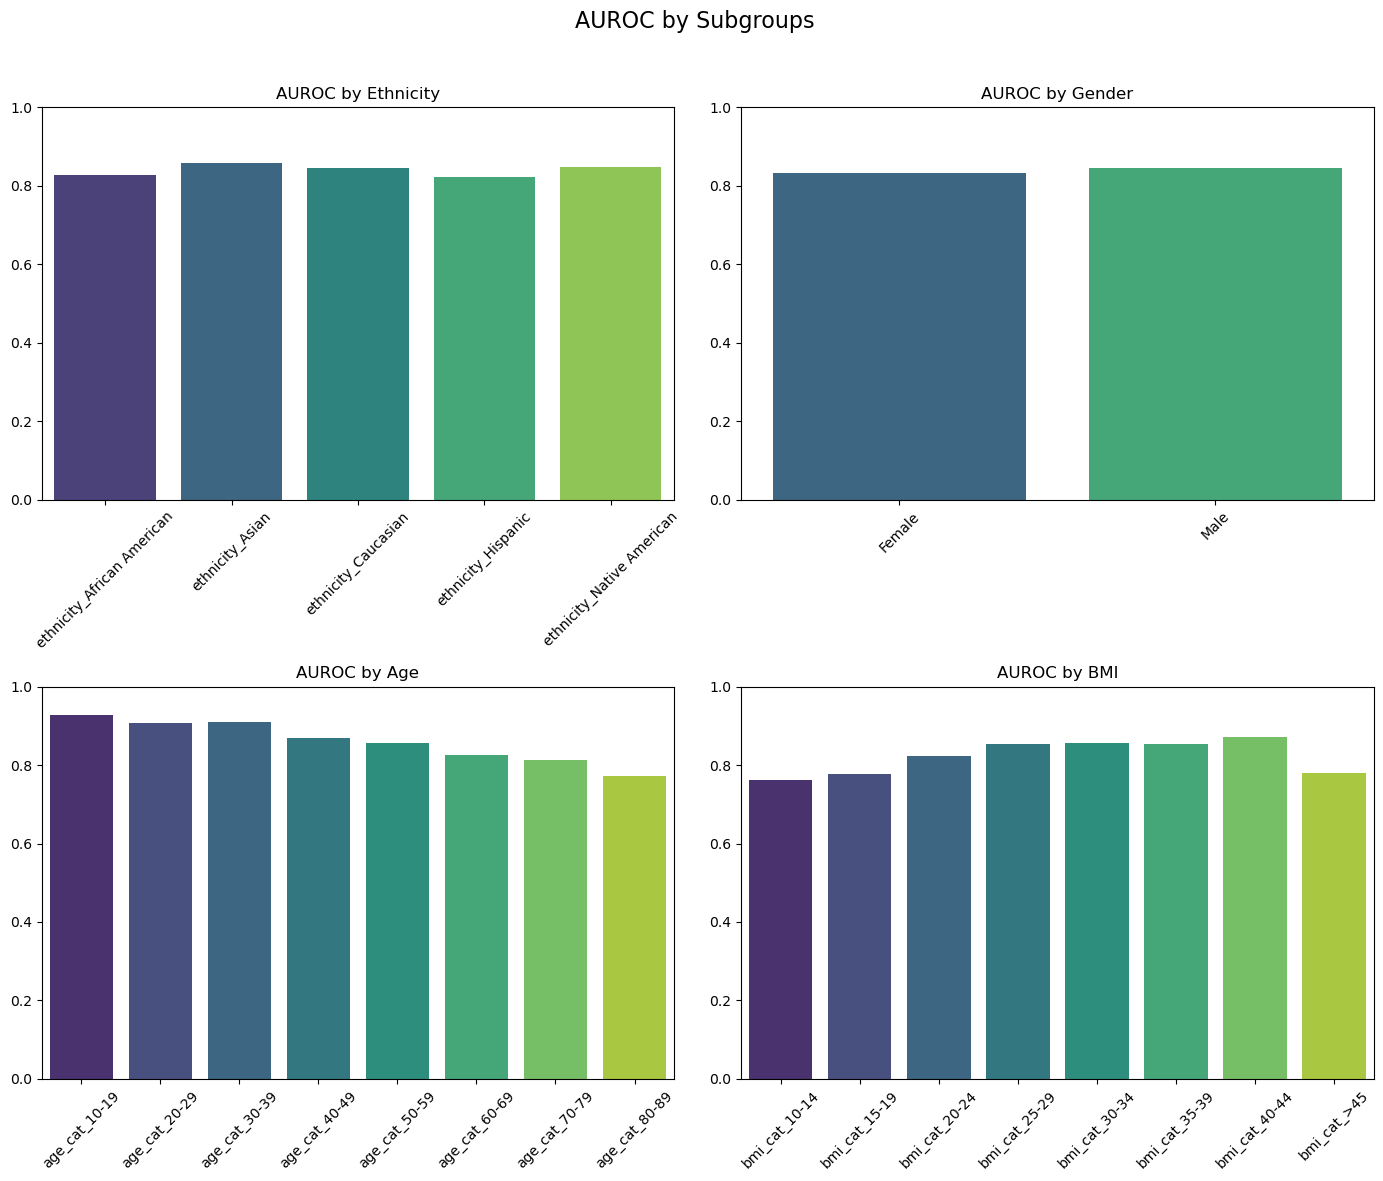

In [60]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score

# Same helper function for ethnicity / age / BMI
def calculate_auroc_by_group(data, group_columns, model, X_test, y_test):
    auroc_scores_else = {}
    for group_column in group_columns:
        # Filter the test set for the current group
        group_indices = (X_test[group_column] == 1)
        X_group = X_test[group_indices]
        y_group = y_test[group_indices]
        
        # Calculate AUROC if the group has enough samples
        if len(y_group) > 0:
            y_pred_proba_group = model.predict_proba(X_group)[:, 1]
            auroc_scores_else[group_column] = roc_auc_score(y_group, y_pred_proba_group)
    
    return auroc_scores_else

# Helper function for a single gender column (by default "gender_F")
def calculate_auroc_for_gender(model, X_test, y_test, gender_column='gender_F'):
    auroc_scores_by_gender = {}

    # Females
    female_indices = (X_test[gender_column] == 1)
    X_female = X_test[female_indices]
    y_female = y_test[female_indices]
    if len(y_female) > 0:
        y_pred_proba_female = model.predict_proba(X_female)[:, 1]
        auroc_scores_by_gender['Female'] = roc_auc_score(y_female, y_pred_proba_female)

    # Males
    male_indices = (X_test[gender_column] == 0)
    X_male = X_test[male_indices]
    y_male = y_test[female_indices == False]  # or simply y_test[male_indices]
    if len(y_male) > 0:
        y_pred_proba_male = model.predict_proba(X_male)[:, 1]
        auroc_scores_by_gender['Male'] = roc_auc_score(y_male, y_pred_proba_male)

    return auroc_scores_by_gender

# Example subgroup columns
ethnicity_columns = [
    'ethnicity_African American',
    'ethnicity_Asian',
    'ethnicity_Caucasian',
    'ethnicity_Hispanic',
    'ethnicity_Native American'
]

age_columns = [
    'age_cat_10-19', 'age_cat_20-29', 'age_cat_30-39',
    'age_cat_40-49', 'age_cat_50-59', 'age_cat_60-69',
    'age_cat_70-79', 'age_cat_80-89'
]

bmi_columns = [
    'bmi_cat_10-14', 'bmi_cat_15-19', 'bmi_cat_20-24', 'bmi_cat_25-29',
    'bmi_cat_30-34', 'bmi_cat_35-39', 'bmi_cat_40-44', 'bmi_cat_>45'
]

data_altered['gender_M'] = 1 - data_altered['gender_F']  # only if "gender_F" exists!

# Now calculate AUROC for each subgroup
auroc_by_ethnicity = calculate_auroc_by_group(
    data_altered, ethnicity_columns, rf_model_altered, X_test_altered, y_test_altered
)

# For gender, we have a simpler specialized function:
auroc_by_gender = calculate_auroc_for_gender(
    rf_model_altered, X_test_altered, y_test_altered, gender_column='gender_F'
)

auroc_by_age = calculate_auroc_by_group(
    data_altered, age_columns, rf_model_altered, X_test_altered, y_test_altered
)

auroc_by_bmi = calculate_auroc_by_group(
    data_altered, bmi_columns, rf_model_altered, X_test_altered, y_test_altered
)

print("AUROC by Ethnicity:", auroc_by_ethnicity)
print("AUROC by Gender:", auroc_by_gender)
print("AUROC by Age:", auroc_by_age)
print("AUROC by BMI:", auroc_by_bmi)

# Finally, plot the four sets of results in a 2x2 grid
fig, axes = plt.subplots(2, 2, figsize=(14, 12))
fig.suptitle('AUROC by Subgroups', fontsize=16)

# 1) Ethnicity
sns.barplot(
    ax=axes[0, 0],
    x=list(auroc_by_ethnicity.keys()),
    y=list(auroc_by_ethnicity.values()),
    palette='viridis'
)
axes[0, 0].set_title('AUROC by Ethnicity')
axes[0, 0].set_ylim(0, 1)
axes[0, 0].tick_params(axis='x', rotation=45)

# 2) Gender
sns.barplot(
    ax=axes[0, 1],
    x=list(auroc_by_gender.keys()),
    y=list(auroc_by_gender.values()),
    palette='viridis'
)
axes[0, 1].set_title('AUROC by Gender')
axes[0, 1].set_ylim(0, 1)
axes[0, 1].tick_params(axis='x', rotation=45)

# 3) Age
sns.barplot(
    ax=axes[1, 0],
    x=list(auroc_by_age.keys()),
    y=list(auroc_by_age.values()),
    palette='viridis'
)
axes[1, 0].set_title('AUROC by Age')
axes[1, 0].set_ylim(0, 1)
axes[1, 0].tick_params(axis='x', rotation=45)

# 4) BMI
sns.barplot(
    ax=axes[1, 1],
    x=list(auroc_by_bmi.keys()),
    y=list(auroc_by_bmi.values()),
    palette='viridis'
)
axes[1, 1].set_title('AUROC by BMI')
axes[1, 1].set_ylim(0, 1)
axes[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [61]:
import pandas as pd

# Calculate AUROC for data_dropnan
auroc_by_ethnicity_dropnan = calculate_auroc_by_group(
    data_dropnan, ethnicity_columns, rf_model, X_test, y_test
)
auroc_by_gender_dropnan = calculate_auroc_for_gender(
    rf_model, X_test, y_test, gender_column='gender_F'
)
auroc_by_age_dropnan = calculate_auroc_by_group(
    data_dropnan, age_columns, rf_model, X_test, y_test
)
auroc_by_bmi_dropnan = calculate_auroc_by_group(
    data_dropnan, bmi_columns, rf_model, X_test, y_test
)

# Create DataFrames for each set of AUROC scores
ethnicity_df = pd.DataFrame({
    'Ethnicity': list(auroc_by_ethnicity.keys()),
    'AUROC_Altered': list(auroc_by_ethnicity.values()),
    'AUROC_Dropnan': list(auroc_by_ethnicity_dropnan.values())
})

gender_df = pd.DataFrame({
    'Gender': list(auroc_by_gender.keys()),
    'AUROC_Altered': list(auroc_by_gender.values()),
    'AUROC_Dropnan': list(auroc_by_gender_dropnan.values())
})

age_df = pd.DataFrame({
    'Age': list(auroc_by_age.keys()),
    'AUROC_Altered': list(auroc_by_age.values()),
    'AUROC_Dropnan': list(auroc_by_age_dropnan.values())
})

bmi_df = pd.DataFrame({
    'BMI': list(auroc_by_bmi.keys()),
    'AUROC_Altered': list(auroc_by_bmi.values()),
    'AUROC_Dropnan': list(auroc_by_bmi_dropnan.values())
})

# Display the DataFrames
print("AUROC by Ethnicity:")
print(ethnicity_df)

print("\nAUROC by Gender:")
print(gender_df)

print("\nAUROC by Age:")
print(age_df)

print("\nAUROC by BMI:")
print(bmi_df)

AUROC by Ethnicity:
                    Ethnicity  AUROC_Altered  AUROC_Dropnan
0  ethnicity_African American       0.826788       0.871244
1             ethnicity_Asian       0.858382       0.844079
2         ethnicity_Caucasian       0.846505       0.836212
3          ethnicity_Hispanic       0.823454       0.879831
4   ethnicity_Native American       0.848219       0.934906

AUROC by Gender:
   Gender  AUROC_Altered  AUROC_Dropnan
0  Female       0.833471       0.830308
1    Male       0.846225       0.851090

AUROC by Age:
             Age  AUROC_Altered  AUROC_Dropnan
0  age_cat_10-19       0.927068       0.904511
1  age_cat_20-29       0.907016       0.885007
2  age_cat_30-39       0.910089       0.900544
3  age_cat_40-49       0.869383       0.877036
4  age_cat_50-59       0.856919       0.872078
5  age_cat_60-69       0.826923       0.834547
6  age_cat_70-79       0.812822       0.811266
7  age_cat_80-89       0.771743       0.765716

AUROC by BMI:
             BMI  AUROC_Alter

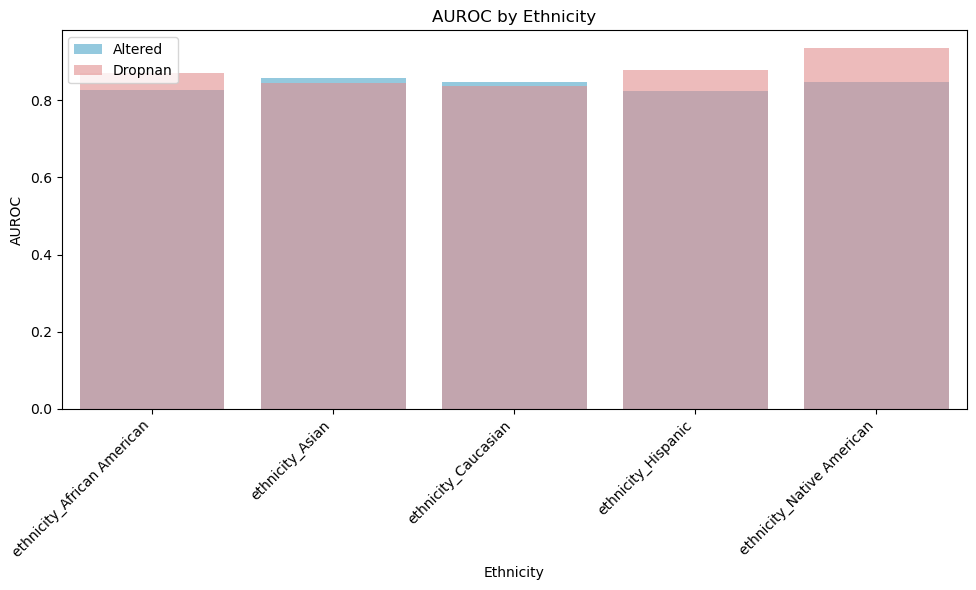

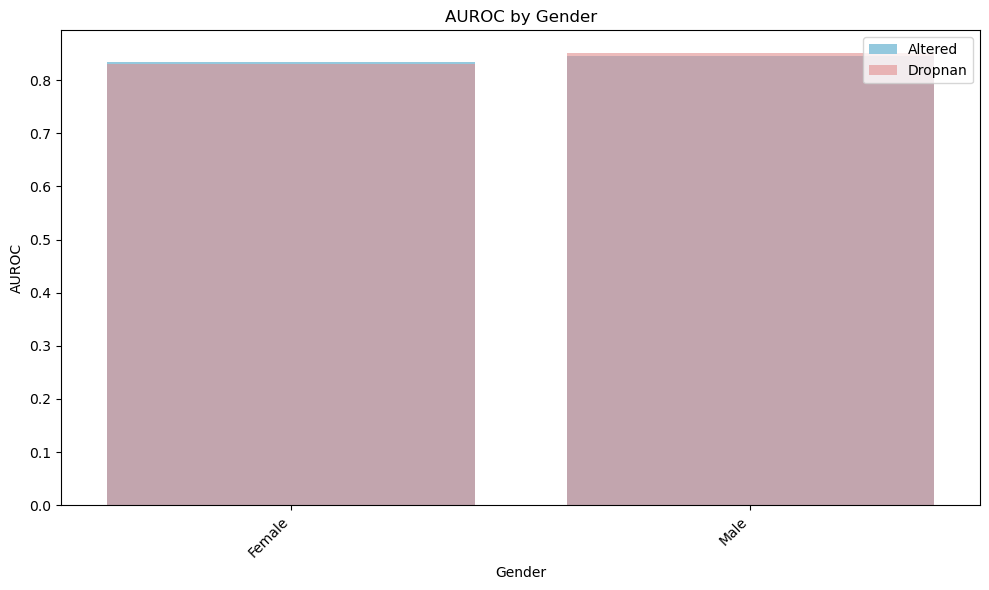

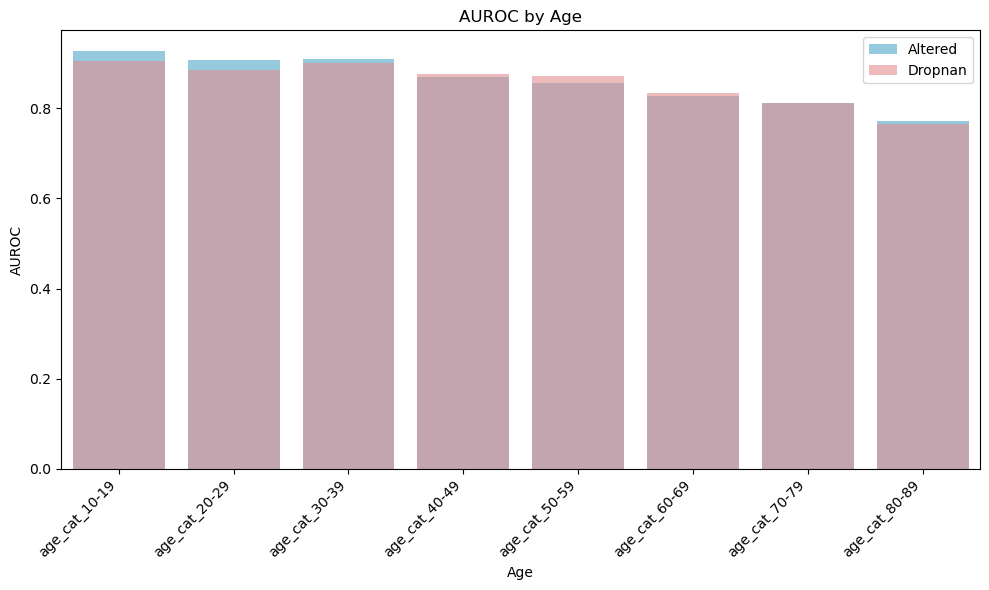

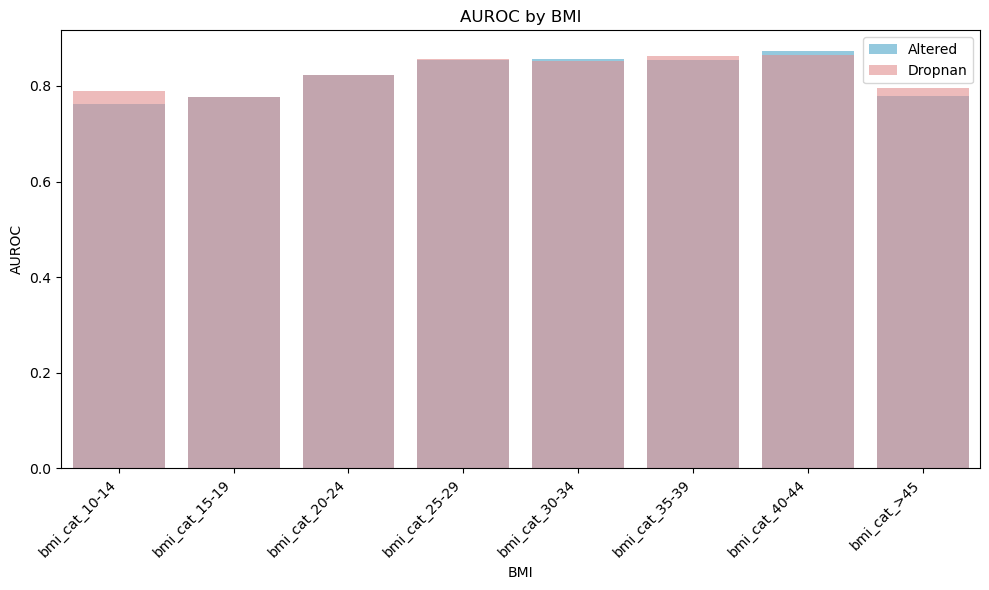

In [62]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_auroc_comparison(df, category, title):
    plt.figure(figsize=(10, 6))
    sns.barplot(x=category, y='AUROC_Altered', data=df, color='skyblue', label='Altered')
    sns.barplot(x=category, y='AUROC_Dropnan', data=df, color='lightcoral', alpha=0.6, label='Dropnan')
    plt.title(title)
    plt.ylabel('AUROC')
    plt.xticks(rotation=45, ha='right')
    plt.legend()
    plt.tight_layout()
    plt.show()

# Plot AUROC comparisons
plot_auroc_comparison(ethnicity_df, 'Ethnicity', 'AUROC by Ethnicity')
plot_auroc_comparison(gender_df, 'Gender', 'AUROC by Gender')
plot_auroc_comparison(age_df, 'Age', 'AUROC by Age')
plot_auroc_comparison(bmi_df, 'BMI', 'AUROC by BMI')